# VAE Attempt

In [46]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [28]:
from tensorflow.keras.utils import image_dataset_from_directory

In [29]:
ds = image_dataset_from_directory('/home/jupyter/data_local', label_mode=None, image_size=(448, 448))

Found 2360 files belonging to 1 classes.


In [30]:
##ds = ds.map(lambda x: x/255)
##ds = ds.map(lambda x: (x, x))

In [31]:
imgs = ds.as_numpy_iterator().__next__()

In [32]:
imgs.shape

(32, 448, 448, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


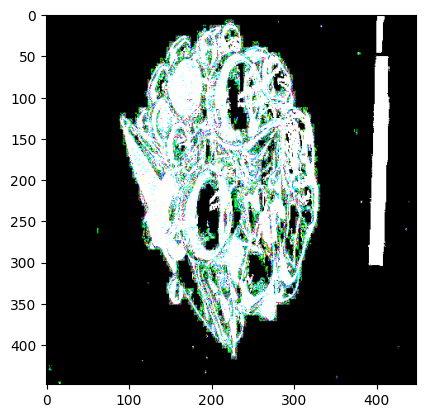

In [33]:
plt.imshow(imgs[0])

In [34]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU

X_train=imgs/255

def build_encoder(latent_dimension):
    encoder = Sequential()
    
    encoder.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(448, 448, 3)))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))
    
    encoder.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU()))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

In [35]:
encoder = build_encoder(latent_dimension=500)

In [36]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose
def build_decoder(latent_dimension):
    decoder = Sequential()
    decoder.add(Dense(7*7*64, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((7, 7, 64)))
    decoder.add(Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid'))
    return decoder

In [37]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 448, 448, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 448, 448, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 224, 224, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                      

In [38]:
decoder = build_decoder(500)

In [39]:
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3136)              1571136   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 128)      73856     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 56, 56, 32)       18464     
 ranspose)                                                       
                                                      

In [40]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
def build_autoencoder(encoder, decoder):
    inp = Input((448, 448, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

In [41]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

In [42]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=10)

compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs=1000, batch_size=32, callbacks=[es], verbose=1)


Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2347
Epoch 2/1000
1/1 [==============================] - 0s 344ms/step - loss: 0.2344
Epoch 3/1000
1/1 [==============================] - 0s 343ms/step - loss: 0.2342
Epoch 4/1000
1/1 [==============================] - 0s 354ms/step - loss: 0.2339
Epoch 5/1000
1/1 [==============================] - 0s 345ms/step - loss: 0.2337
Epoch 6/1000
1/1 [==============================] - 0s 348ms/step - loss: 0.2335
Epoch 7/1000
1/1 [==============================] - 0s 344ms/step - loss: 0.2332
Epoch 8/1000
1/1 [==============================] - 0s 344ms/step - loss: 0.2330
Epoch 9/1000
1/1 [==============================] - 0s 350ms/step - loss: 0.2327
Epoch 10/1000
1/1 [==============================] - 0s 350ms/step - loss: 0.2324
Epoch 11/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.2322
Epoch 12/1000
1/1 [==============================] - 0s 348ms/step - loss: 0.2319
Epoch 13/1000
1/1 [=========

In [43]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=32)# you can now display an image to see it is reconstructed well
    

In [44]:
prediction.shape

(32, 448, 448, 3)

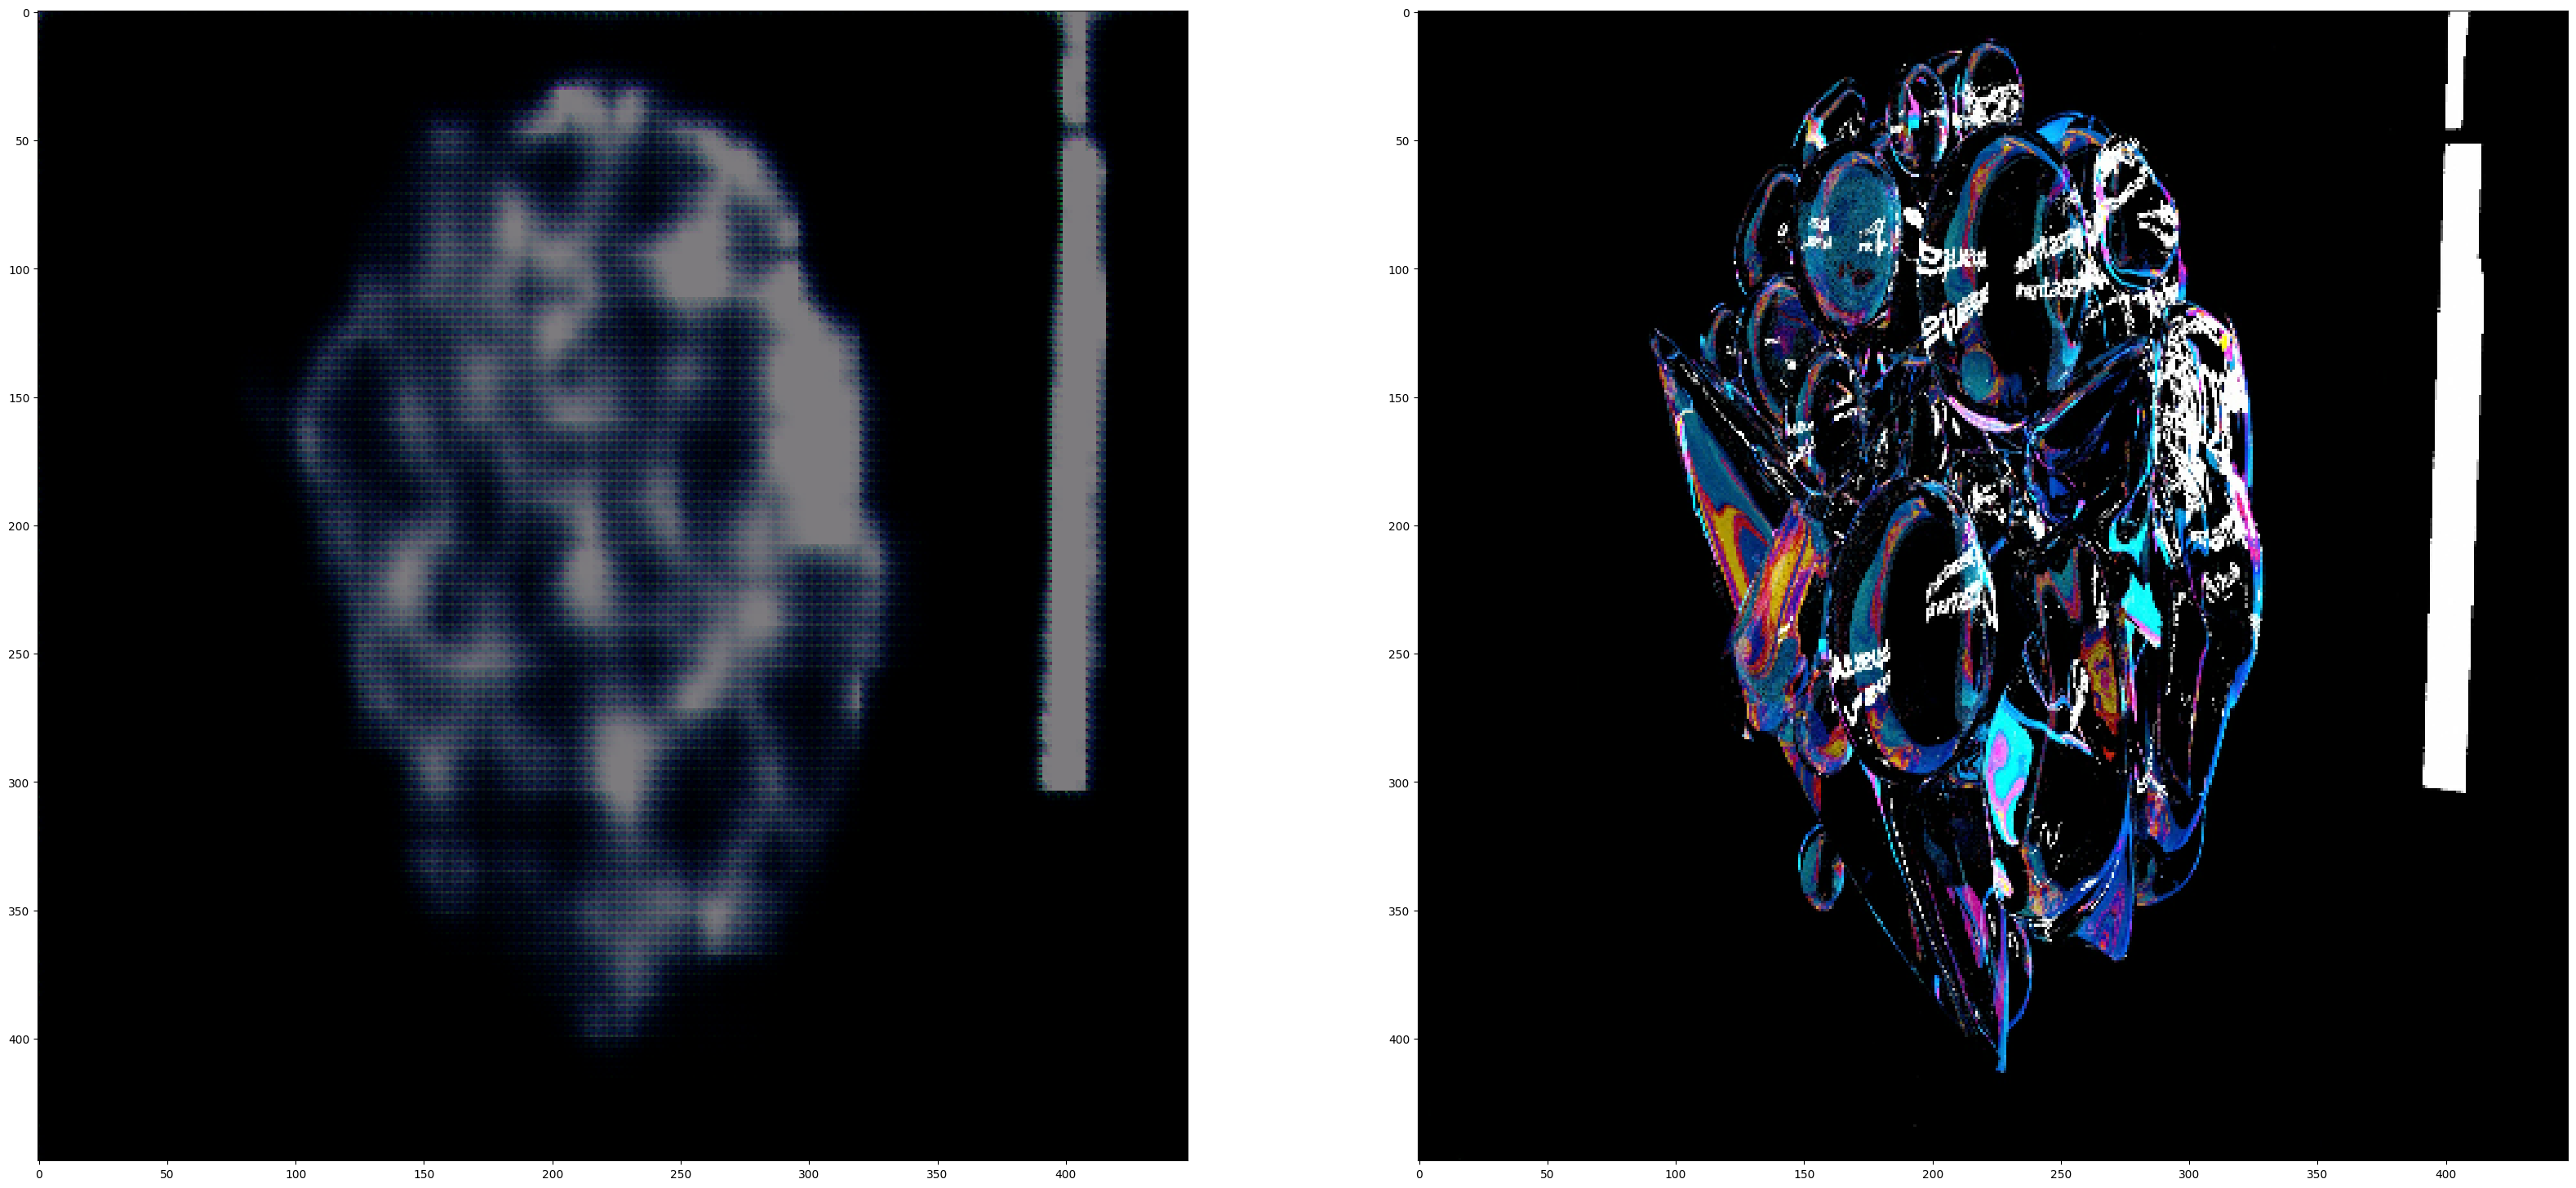

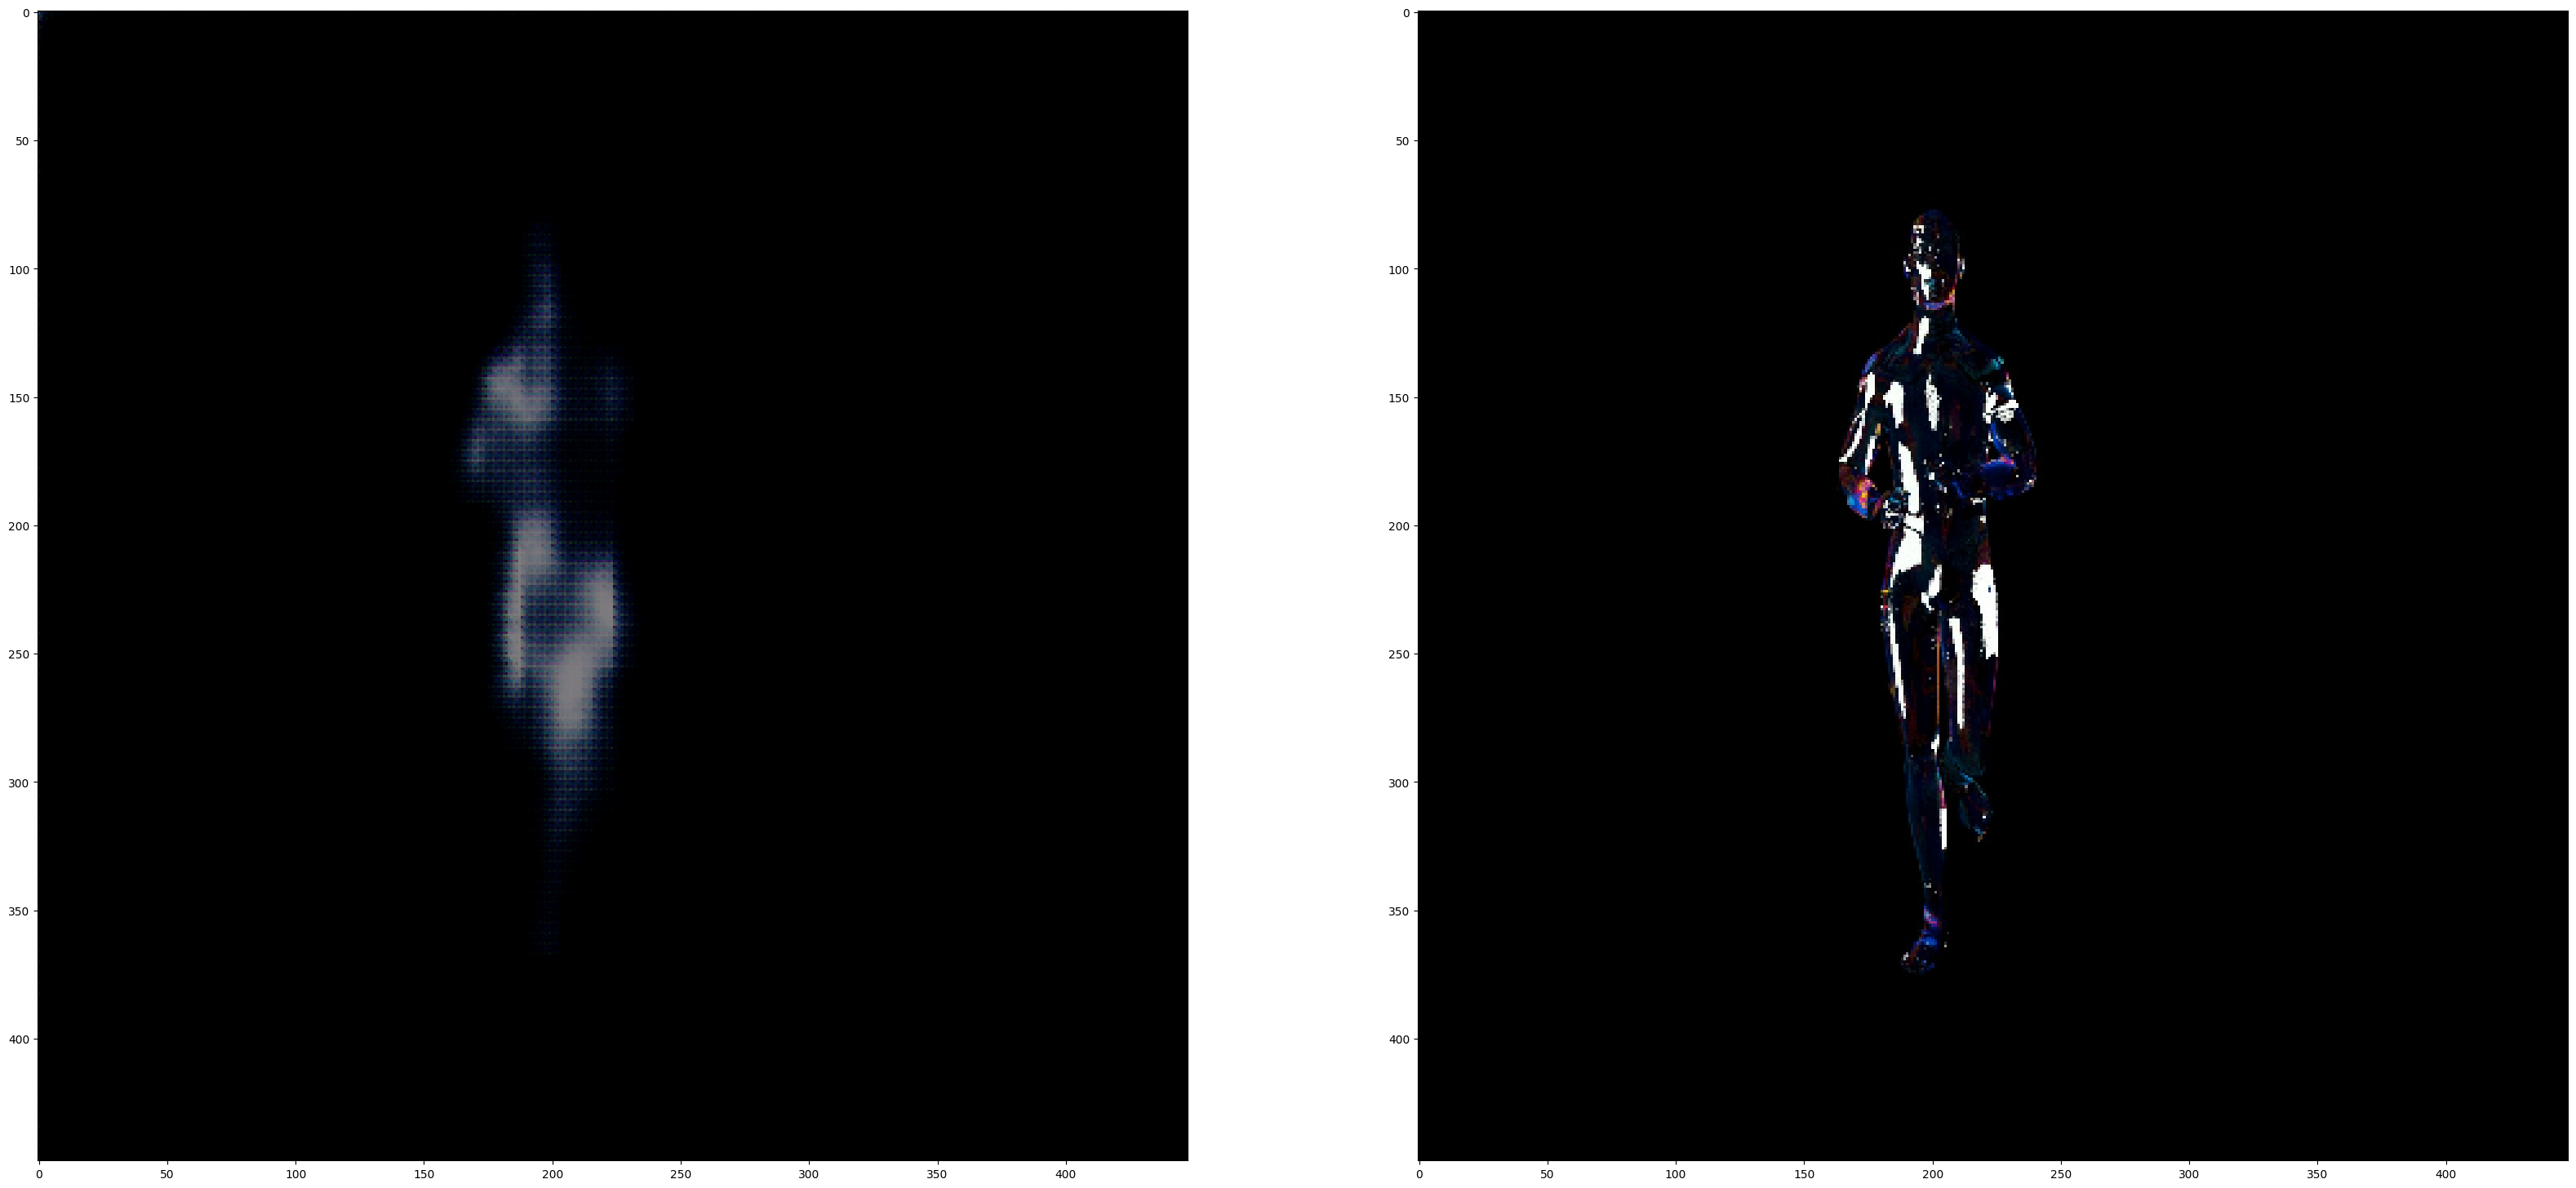

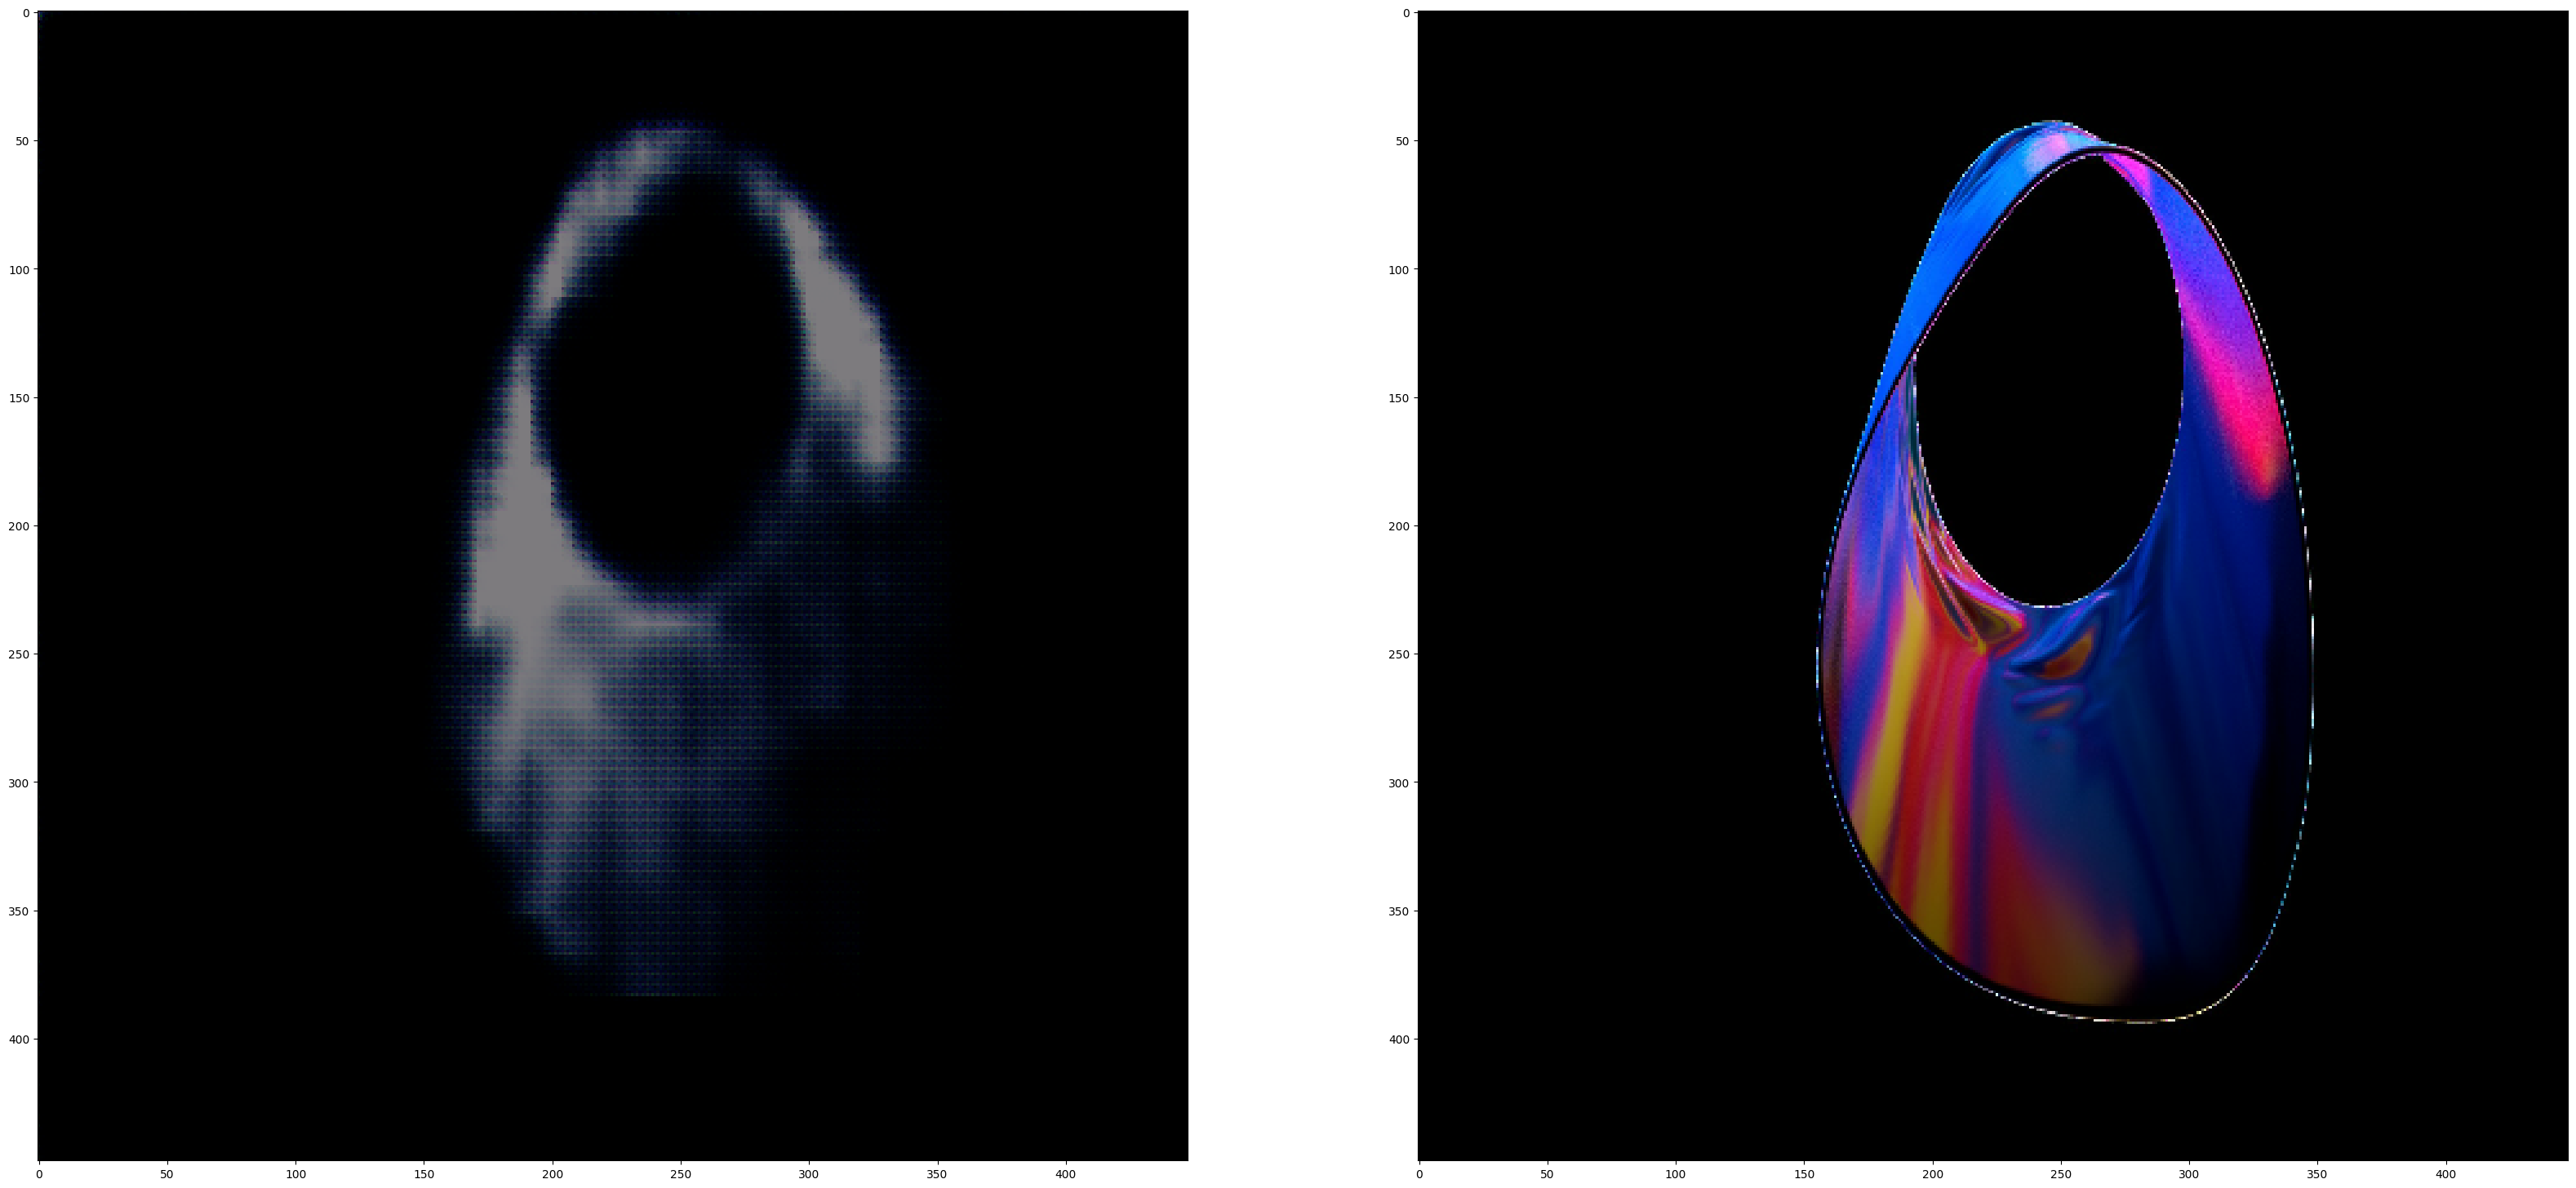

In [45]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(448, 448, 3))
    plt.show()

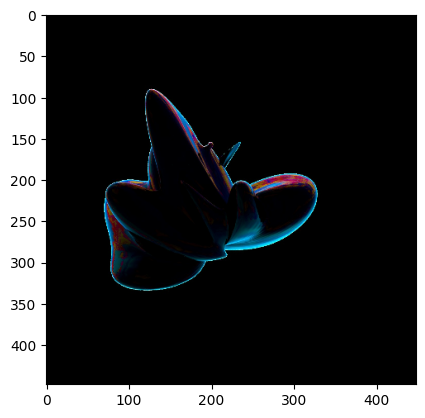

In [23]:
plt.imshow(X_train[10])